In [1]:
%matplotlib inline

In [2]:
from empirical_disk_bulge.observations import load_umachine_sdss_complete

sdss = load_umachine_sdss_complete()
mask = sdss['type_mendel13'] != 4
mask *= sdss['deltaBD_mendel13'] <= 1
cut_sdss = sdss[mask]

from empirical_disk_bulge.observations import sfr_sequence_bulge_disk_fractions_vs_sm as bt_measurement
_result = bt_measurement(cut_sdss['bt'], cut_sdss['sm'], cut_sdss['ssfr'])

sm_abscissa_sdss, frac_disk_dom_all_sdss, frac_bulge_dom_all_sdss,\
    frac_disk_dom_sfs_sdss, frac_bulge_dom_sfs_sdss, \
    frac_disk_dom_gv_sdss, frac_bulge_dom_gv_sdss, \
    frac_disk_dom_q_sdss, frac_bulge_dom_q_sdss = _result


In [3]:
from umachine_pyio.load_mock import value_added_mock, load_mock_from_binaries
subvolumes = np.random.choice(np.arange(144), 50, replace=False)
galprops = ('upid', 'obs_sfr', 'icl', 'sfr_history_main_prog', 'mpeak', 
            'sfr', 'halo_id', 'mvir', 'rvir', 'vx', 'sm', 'vy', 'y', 
           'x', 'sm_history_main_prog', 'z', 'vz', 'obs_sm','dvmax_zscore_history')
vamock = value_added_mock(load_mock_from_binaries(subvolumes, galprops=galprops), 250)
print(vamock.keys())
sfrh, smh = vamock['sfr_history_main_prog'].data, vamock['sm_history_main_prog'].data
sm = np.log10(vamock['obs_sm'].data)
ssfr = np.log10(vamock['obs_sfr'].data/vamock['obs_sm'].data)
dvh = vamock['dvmax_zscore_history']
from umachine_pyio.load_mock import get_snapshot_times
cosmic_age_array = get_snapshot_times()


Total runtime = 11.95 seconds
['upid', 'rvir', 'obs_sfr', 'y', 'dvmax_zscore_history', 'icl', 'sfr_history_main_prog', 'sfr', 'mpeak', 'halo_id', 'vx', 'sm', 'x', 'mvir', 'vy', 'sm_history_main_prog', 'z', 'vz', 'obs_sm', 'halo_hostid', 'host_halo_rvir', 'host_halo_mvir']


In [4]:
from empirical_disk_bulge.models import ssfr_dependent_disruption
# from empirical_disk_bulge.models import merger_triggered_disruption

def model_prediction(params, sm, ssfr, smh, sfrh, tarr):
    frac_migration, prob1, prob2 = params

    zobs = 0.
    sm_disk, sm_bulge, disruption_history = ssfr_dependent_disruption(sfrh, smh, tarr, zobs, 
                                                   frac_migration, prob1, prob2, 
                                                 return_disruption_history=True)
    bt = sm_bulge/(sm_disk + sm_bulge)
    
    return bt_measurement(bt, sm, ssfr, return_data_vector=False), disruption_history

# def vmax_model_prediction(params, sm, ssfr, smh, sfrh, dvh, tarr):
#     from empirical_disk_bulge.models import delta_vmax_dependent_disruption

#     frac_migration, = params

#     zobs = 0.
#     sm_disk, sm_bulge, disruption_history = delta_vmax_dependent_disruption(sfrh, smh, dvh, tarr, zobs, 
#                                                    frac_migration, return_disruption_history=True)
#     bt = sm_bulge/(sm_disk + sm_bulge)
    
#     return bt_measurement(bt, sm, ssfr, return_data_vector=False), disruption_history
 
# def merger_model_prediction(params, sm, ssfr, smh, sfrh, muh, tarr):
#     frac_migration,  = params

#     zobs = 0.
#     sm_disk, sm_bulge, disruption_history = merger_triggered_disruption(sfrh, smh, muh, 
#                                                 tarr, zobs, frac_migration, 
#                                                  return_disruption_history=True)
#     bt = sm_bulge/(sm_disk + sm_bulge)
    
#     return bt_measurement(bt, sm, ssfr, return_data_vector=False), disruption_history

    

In [5]:
frac_migration_longchain, prob1_longchain, prob2_longchain = 0.3635, 0.336, 0.0483
frac_migration_shortchain, prob1_shortchain, prob2_shortchain = 0.3246, 0.2956, 0.2542


In [6]:
frac_migration, prob1, prob2 = frac_migration_longchain, prob1_longchain, prob2_longchain
params1 = frac_migration, prob1, prob2

bt_result_model1, disruption_history_model1 = model_prediction(params1, sm, ssfr, smh, sfrh, cosmic_age_array)

sm_abscissa_model1, frac_disk_dom_all_model1, frac_bulge_dom_all_model1,\
    frac_disk_dom_sfs_model1, frac_bulge_dom_sfs_model1, \
    frac_disk_dom_gv_model1, frac_bulge_dom_gv_model1, \
    frac_disk_dom_q_model1, frac_bulge_dom_q_model1 = bt_result_model1


In [7]:
frac_migration, prob1, prob2 = frac_migration_shortchain, prob1_shortchain, prob2_shortchain
params2 = frac_migration, prob1, prob2

bt_result_model2, disruption_history_model2 = model_prediction(params1, sm, ssfr, smh, sfrh, cosmic_age_array)

sm_abscissa_model2, frac_disk_dom_all_model2, frac_bulge_dom_all_model2,\
    frac_disk_dom_sfs_model2, frac_bulge_dom_sfs_model2, \
    frac_disk_dom_gv_model2, frac_bulge_dom_gv_model2, \
    frac_disk_dom_q_model2, frac_bulge_dom_q_model2 = bt_result_model2


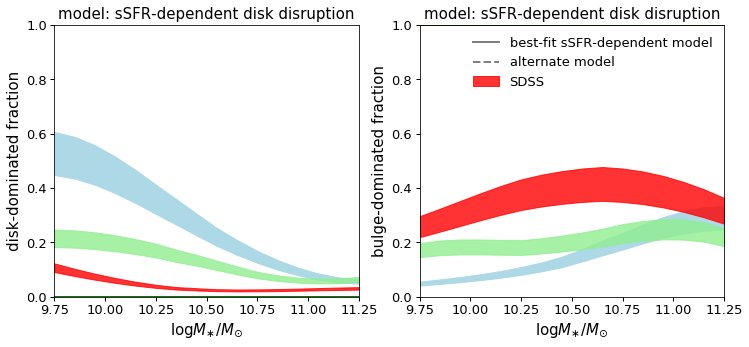

In [8]:
from scipy.signal import savgol_filter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

a, b = 11, 3

fracerr = 0.15
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_sfs_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=1)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_gv_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_disk_dom_q_sdss, a, b))
__=ax1.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_sfs_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightblue', alpha=1)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_gv_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='lightgreen', alpha=0.8)
ylow, yhigh = ((1-fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b), 
               (1+fracerr)*savgol_filter(frac_bulge_dom_q_sdss, a, b))
__=ax2.fill_between(sm_abscissa_sdss, ylow, yhigh, color='red', alpha=0.8, label='SDSS')

xlabel1 = ax1.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
xlabel2 = ax2.set_xlabel(r'$\log M_{\ast}/M_{\odot}$', size=15)
ylabel1 = ax1.set_ylabel(r'disk-dominated fraction', size=15)
ylabel2 = ax2.set_ylabel(r'bulge-dominated fraction', size=15)

xmin, xmax = 9.75, 11.25
xlim1 = ax1.set_xlim(xmin, xmax)
xlim2 = ax2.set_xlim(xmin, xmax)
ymin, ymax = 0, 1
ylim1 = ax1.set_ylim(ymin, ymax)
ylim2 = ax2.set_ylim(ymin, ymax)

### Model 1
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax1.plot(sm_abscissa_model1, savgol_filter(frac_disk_dom_gv_model1, a, b), 
            color='green', lw=2, label='best-fit sSFR-dependent model')

__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_sfs_model1, a, b), 
            color='blue', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_q_model1, a, b), 
            color='red', lw=2)
__=ax2.plot(sm_abscissa_model1, savgol_filter(frac_bulge_dom_gv_model1, a, b), 
            color='green', label='best-fit sSFR-dependent model', lw=2)


### Model 2
__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_sfs_model2, a, b), 
            '--', color='blue', lw=2)
__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_q_model2, a, b), 
            '--', color='red', lw=2)
__=ax1.plot(sm_abscissa_model2, savgol_filter(frac_disk_dom_gv_model2, a, b), 
            '--', color='green', lw=2, label='alternate model')

__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_sfs_model2, a, b), 
            '--', color='blue', lw=2)
__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_q_model2, a, b), 
            '--', color='red', lw=2)
__=ax2.plot(sm_abscissa_model2, savgol_filter(frac_bulge_dom_gv_model2, a, b), 
            '--', color='green', label='alternate model', lw=2)


legend2 = ax2.legend()
legend2.legendHandles[0].set_color('gray')
legend2.legendHandles[1].set_color('gray')

title1 = ax1.set_title(r'model: sSFR-dependent disk disruption')
title2 = ax2.set_title(r'model: sSFR-dependent disk disruption')


# Examine disruption histories

In [ ]:
drh1, drh2 = disruption_history_model1, disruption_history_model2

In [ ]:
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')

mask1 = (vamock['sm'] > 10**9.75) & (vamock['sm'] < 10**10)
mean_sm1_mask1 = np.mean(vamock[mask1]['sm_history_main_prog'], axis=0)
__=ax.plot(cosmic_age_array, mean_sm1_mask1, color='k')

mean_drh1_mask1 = np.mean(drh1[mask1], axis=0)
__=ax.plot(cosmic_age_array, mean_drh1_mask1, color='red')

mean_drh2_mask1 = np.mean(drh2[mask1], axis=0)
__=ax.plot(cosmic_age_array, mean_drh2_mask1, color='blue')


In [ ]:
mean_drh1_mask1.min(), mean_drh1_mask1.max()

In [ ]:
fig, ax = plt.subplots(1, 1)


np.mean(drh1 > 0, axis=0).shape
mask1 = (vamock['sm'] > 10**9.75) & (vamock['sm'] < 10**10)

__=ax.hist(np.sum(drh1[mask1]>0, axis=1), alpha=0.8)
__=ax.hist(np.sum(drh2[mask1]>0, axis=1), alpha=0.8)

In [ ]:
disruption_counts_mask1.min(), disruption_counts_mask1.max()